In [ ]:
!pip install torchdata
!pip install -U torchtext==0.13.0
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.0 MB/s 
     |████████████████████████████████| 776.3 MB 13 kB/s 
     |████████████████████████████████| 139 kB 70.1 MB/s 
     |████████████████████████████████| 127 kB 68.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.12.1 wh

In [ ]:
import torch
import torchtext
import datasets

# Used hugging face tutorial as a starting point: https://notebooks.githubusercontent.com/view/ipynb?azure_maps_enabled=false&browser=chrome&color_mode=auto&commit=b4efbefa47672174394a8b6a27d4e7bc193bc224&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f62656e747265766574742f7079746f7263682d73656e74696d656e742d616e616c797369732f623465666265666134373637323137343339346138623661323764346537626331393362633232342f746f726368746578745f305f31305f696d64625f6e626f772e6970796e62&enterprise_enabled=false&logged_in=false&nwo=bentrevett%2Fpytorch-sentiment-analysis&path=torchtext_0_10_imdb_nbow.ipynb&platform=android&repository_id=114125096&repository_type=Repository&version=102

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# get dataset from hugging face library
train_data, test_data = datasets.load_dataset('imdb', split = ['train', 'test'])

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
# FOR TESTING PURPOSES ONLY
train_data = train_data[:15000]
train_data = datasets.Dataset.from_dict(train_data)

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
from torchtext.data.utils import get_tokenizer

# use a standard english tokenizer
tokenizer = get_tokenizer('basic_english')

In [ ]:
# function that tokenizes the data
def tokenize_data(ex):
  tokens = {'tokens': tokenizer(ex['text'])}
  return tokens

In [ ]:
# add a tokens column with the tokens for each text review
# Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.map
train_data = train_data.map(tokenize_data)
test_data = test_data.map(tokenize_data)

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [ ]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [ ]:
#Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.train_test_split
# split the training data into training and validation data
train_valid_data = train_data.train_test_split() # default test_size is 0.25
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [ ]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [ ]:
from torchtext.vocab import Vocab, build_vocab_from_iterator

UNK_IDX, PAD_IDX = 0, 1
special_symbols = ['<unk>', '<pad>']

# build vocab from the text tokens from training data
vocab = build_vocab_from_iterator(train_data['tokens'], min_freq = 50, specials = special_symbols)

# set unknown index as the default
vocab.set_default_index(UNK_IDX)


In [ ]:
len(vocab)

5848

In [ ]:
vocab.get_itos()[:5]

['<unk>', '<pad>', 'the', '.', ',']

In [ ]:
# transform the tokens into numerical values 
def transform_tokens(ex):
  idxs = {'idxs': [vocab[token] for token in ex['tokens']]}
  return idxs

In [ ]:
# add a column with the idxs
train_data = train_data.map(transform_tokens)
valid_data = valid_data.map(transform_tokens)
test_data = test_data.map(transform_tokens)

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [ ]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 25000
 }))

In [ ]:
train_data[0] # labels are 0 (neg) and 1 (pos)

{'idxs': [186,
  1961,
  11,
  472,
  45,
  1513,
  617,
  7,
  3217,
  18,
  81,
  3,
  54,
  10,
  11,
  55,
  54,
  10,
  11,
  50,
  83,
  1168,
  15,
  13,
  49,
  58,
  9,
  27,
  862,
  107,
  1184,
  55,
  13,
  485,
  30,
  49,
  193,
  105,
  0,
  28,
  117,
  605,
  620,
  5,
  0,
  41,
  814,
  3,
  13,
  378,
  95,
  0,
  14,
  10,
  4,
  22,
  906,
  30,
  0,
  56,
  171,
  121,
  3155,
  13,
  58,
  9,
  27,
  131,
  74,
  96,
  1978,
  35,
  3,
  30,
  9,
  16,
  6,
  660,
  411,
  5,
  10,
  1550,
  1238,
  1442,
  20,
  117,
  6,
  1007,
  5,
  0,
  283,
  3,
  30,
  9,
  16,
  49,
  29,
  3,
  13,
  204,
  96,
  1083,
  19,
  272,
  44,
  276,
  4,
  5,
  117,
  501,
  8,
  1330,
  38,
  2,
  2619,
  7,
  6,
  2478,
  3,
  15,
  9,
  16,
  50,
  11,
  3,
  1513,
  5495,
  17,
  248,
  7,
  41,
  0,
  19,
  78,
  4,
  215,
  43,
  2,
  380,
  3,
  2,
  1753,
  0,
  683,
  168,
  9,
  27,
  4014,
  78,
  12,
  107,
  103,
  3,
  13,
  280,
  9,
  27,
  1912,
  8,
  129

In [ ]:
# SIMPLE RNN MODEL
from torch import nn

class RNN(nn.Module):
# I referred to this tutorial for help: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim):
        super().__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # RNN layer
        self.rnn = nn.RNN(emb_dim, hid_dim) # default batch_first is False
        # linear layer
        self.linear = nn.Linear(hid_dim, output_dim)
    def forward(self, text):
        # input text is dimension [seq_len, batch_size]
        # apply embeddings to the words
        embedded = self.embedding(text)
        # embedded is dimension [seq_len, batch_size, emb_dim] because batch_first = False
        # run through RNN
        output, hidden = self.rnn(embedded)
        # hidden is dimension [1, batch_size, hid_dim]
        # get the predictions
        scores = self.linear(hidden.squeeze(0))
        # scores should have the dimension [batch_size, output_dim]
        return scores

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# collate function to put examples in batches 
def collate_batch(batch):
  batch_idxs, batch_labels = [], []

  for b in batch: 
    #print(b)
    batch_idxs.append(torch.LongTensor(b['idxs']))
    batch_labels.append(torch.tensor(b['label']))

  # pad idxs that are shorter than the longest sentence
  batch_idxs = pad_sequence(batch_idxs, batch_first = False, padding_value = PAD_IDX)
  batch_labels = torch.stack(batch_labels)

  batch = {'idxs': batch_idxs,
           'labels': batch_labels}
  
  return batch


In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

RNN(
  (embedding): Embedding(5848, 50)
  (rnn): RNN(50, 128)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 500

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [ ]:
for i, b in enumerate(train_dataloader):
  print('b')
  print(b)

  if i > -1:
    break

b
{'idxs': tensor([[   13,     0,    12,  ...,  7346,     2,  6783],
        [   75,  6581,    37,  ..., 13186,   291,   163],
        [    6,     3,   889,  ...,     9,     7,  9692],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]]), 'labels': tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 

In [ ]:
import torch.optim as optim

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=3)

In [ ]:
def get_accuracy(predictions, actual_labels):
  batch_size = predictions.shape[0]
  predicted_labels = predictions.argmax(1)
  num_correct = (predicted_labels == actual_labels).sum()
  accuracy = num_correct / batch_size
  return accuracy


In [ ]:
def train(dataloader):
  model.train()

  epoch_loss, epoch_accuracy = 0, 0
  log_interval = 500

  for idx, batch in enumerate(dataloader):
    token_ids = batch['idxs'].to(device)
    labels = batch['labels'].to(device)
    optimizer.zero_grad()
    predictions = model(token_ids)
    loss = criterion(predictions, labels)
    accuracy = get_accuracy(predictions, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy.item()

    #if idx % log_interval == 0 and idx > 0:
    #  print(f'At iteration {idx} the loss is {loss:.3f}.')
    #  print(f'At iteration {idx} the accuracy is {accuracy:.3f}.')

  return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)


In [ ]:
def evaluate(dataloader):
  model.eval()

  epoch_loss, epoch_accuracy = 0, 0

  with torch.no_grad():
    for idx, batch in enumerate(dataloader):
      token_ids = batch['idxs'].to(device)
      labels = batch['labels'].to(device)
      predictions = model(token_ids)
      loss = criterion(predictions, labels)
      accuracy = get_accuracy(predictions, labels)
      epoch_loss += loss.item()
      epoch_accuracy += accuracy.item()
  
  return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)
  

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Epoch: 01 | Time: 0m 27s
train_loss: 82.941, train_acc: 0.503
valid_loss: 49.117, valid_acc: 0.510
test_loss: 50.186, test_acc: 0.500
Epoch: 02 | Time: 0m 24s
train_loss: 40.084, train_acc: 0.504
valid_loss: 6.569, valid_acc: 0.510
test_loss: 6.740, test_acc: 0.500
Epoch: 03 | Time: 0m 25s
train_loss: 62.988, train_acc: 0.502
valid_loss: 57.462, valid_acc: 0.510
test_loss: 58.693, test_acc: 0.500
Epoch: 04 | Time: 0m 24s
train_loss: 35.252, train_acc: 0.502
valid_loss: 27.361, valid_acc: 0.490
test_loss: 26.866, test_acc: 0.500
Epoch: 05 | Time: 0m 24s
train_loss: 58.958, train_acc: 0.495
valid_loss: 3.530, valid_acc: 0.510
test_loss: 3.637, test_acc: 0.500
Epoch: 06 | Time: 0m 24s
train_loss: 35.256, train_acc: 0.499
valid_loss: 15.536, valid_acc: 0.510
test_loss: 15.891, test_acc: 0.500
Epoch: 07 | Time: 0m 24s
train_loss: 53.920, train_acc: 0.499
valid_loss: 24.816, valid_acc: 0.490
test_loss: 24.369, test_acc: 0.500
Epoch: 08 | Time: 0m 24s
train_loss: 37.732, train_acc: 0.502
vali

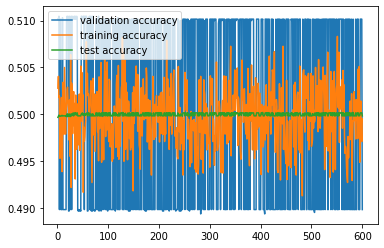

In [ ]:
# with vocab 45307
N_EPOCHS = 600
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)
  test_loss, test_acc = evaluate(test_dataloader)

  end_time = time.time()
  
  valid_accuracies.append(valid_acc)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
  print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 27s
train_loss: 70.094, train_acc: 0.507
valid_loss: 19.741, valid_acc: 0.505
test_loss: 19.949, test_acc: 0.500
Epoch: 02 | Time: 0m 26s
train_loss: 45.902, train_acc: 0.497
valid_loss: 28.768, valid_acc: 0.495
test_loss: 28.470, test_acc: 0.500
Epoch: 03 | Time: 0m 26s
train_loss: 48.128, train_acc: 0.498
valid_loss: 38.382, valid_acc: 0.495
test_loss: 37.985, test_acc: 0.500
Epoch: 04 | Time: 0m 27s
train_loss: 57.047, train_acc: 0.503
valid_loss: 102.729, valid_acc: 0.495
test_loss: 101.666, test_acc: 0.500
Epoch: 05 | Time: 0m 26s
train_loss: 55.311, train_acc: 0.498
valid_loss: 47.164, valid_acc: 0.505
test_loss: 47.662, test_acc: 0.500
Epoch: 06 | Time: 0m 26s
train_loss: 54.345, train_acc: 0.502
valid_loss: 79.095, valid_acc: 0.505
test_loss: 79.931, test_acc: 0.500
Epoch: 07 | Time: 0m 26s
train_loss: 74.519, train_acc: 0.501
valid_loss: 88.316, valid_acc: 0.495
test_loss: 87.402, test_acc: 0.500
Epoch: 08 | Time: 0m 26s
train_loss: 23.207, train_acc: 0.50

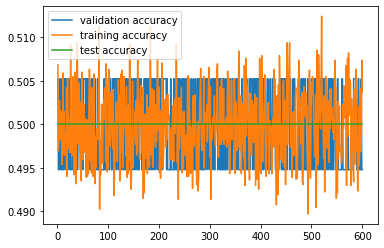

In [35]:
# with vocab 5848
N_EPOCHS = 600
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)
  test_loss, test_acc = evaluate(test_dataloader)

  end_time = time.time()
  
  valid_accuracies.append(valid_acc)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
  print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(test_dataloader)
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

test_loss: 0.979, test_acc: 0.498


In [ ]:
# GRU MODEL
from torch import nn

class GRU(nn.Module):
# I referred to this tutorial for help: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim):
        super().__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # RNN layer
        self.gru = nn.GRU(emb_dim, hid_dim) # default batch_first is False
        # linear layer
        self.linear = nn.Linear(hid_dim, output_dim)
    def forward(self, text):
        # input text is dimension [seq_len, batch_size]
        # apply embeddings to the words
        embedded = self.embedding(text)
        # embedded is dimension [seq_len, batch_size, emb_dim] because batch_first = False
        # run through RNN
        output, hidden = self.gru(embedded)
        # hidden is dimension [1, batch_size, hid_dim]
        # get the predictions
        scores = self.linear(hidden.squeeze(0))
        # scores should have the dimension [batch_size, output_dim]
        return scores

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 5 #100
HIDDEN_DIM = 10 #256
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = GRU(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
BATCH_SIZE = 128

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [ ]:
# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=2)

In [ ]:
N_EPOCHS = 150
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  
  start_time = time.time()

  train_loss, train_acc = train(train_dataloader)
  valid_loss, valid_acc = evaluate(valid_dataloader)

  end_time = time.time()
    
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'tut2-model.pt')

  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
  print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')

Epoch: 01 | Time: 0m 13s
train_loss: 1.584, train_acc: 0.502
valid_loss: 1.135, valid_acc: 0.500
Epoch: 02 | Time: 0m 12s
train_loss: 1.028, train_acc: 0.514
valid_loss: 0.877, valid_acc: 0.500
Epoch: 03 | Time: 0m 12s
train_loss: 1.169, train_acc: 0.512
valid_loss: 0.899, valid_acc: 0.495
Epoch: 04 | Time: 0m 12s
train_loss: 1.237, train_acc: 0.506
valid_loss: 1.106, valid_acc: 0.498
Epoch: 05 | Time: 0m 12s
train_loss: 1.503, train_acc: 0.502
valid_loss: 0.941, valid_acc: 0.498
Epoch: 06 | Time: 0m 13s
train_loss: 1.365, train_acc: 0.505
valid_loss: 0.747, valid_acc: 0.489
Epoch: 07 | Time: 0m 13s
train_loss: 1.634, train_acc: 0.497
valid_loss: 0.762, valid_acc: 0.501
Epoch: 08 | Time: 0m 12s
train_loss: 1.629, train_acc: 0.502
valid_loss: 0.826, valid_acc: 0.510
Epoch: 09 | Time: 0m 12s
train_loss: 1.512, train_acc: 0.506
valid_loss: 0.817, valid_acc: 0.501
Epoch: 10 | Time: 0m 12s
train_loss: 1.005, train_acc: 0.505
valid_loss: 1.109, valid_acc: 0.502
Epoch: 11 | Time: 0m 12s
train